# Time Series and Forecasting Weather Project

I undertook a project centered around time series analysis and forecasting of weather data in Reykjavik, Iceland. The project involved analyzing historical weather patterns and utilizing the SARIMA (Seasonal ARIMA) model to predict future temperature trends. By applying advanced modeling techniques, the project aimed to gain insights into the region's weather patterns and contribute to improved forecasting accuracy.

Data downloaded from https://en.vedur.is/climatology/data/.

In [1]:
# Import necessary libraries to complete the project
import chardet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Using chardet to find and open with correct encoding
with open('weather_data.txt', 'rb') as f:
    result = chardet.detect(f.read())
encoding = result['encoding']

In [3]:
# Read in data
df = pd.read_csv('weather_data.txt', sep='\t', encoding=encoding)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   stöð    893 non-null    int64  
 1    ár     893 non-null    int64  
 2   mán     893 non-null    int64  
 3     t     893 non-null    float64
 4     tx    893 non-null    float64
 5     txx   893 non-null    float64
 6   txxD1   893 non-null    int64  
 7     tn    893 non-null    float64
 8    tnn    893 non-null    float64
 9   tnnD1   893 non-null    int64  
 10   rh     893 non-null    float64
 11   r      893 non-null    float64
 12   rx     893 non-null    float64
 13  rxD1    893 non-null    int64  
 14   p      893 non-null    float64
 15   n      893 non-null    float64
 16  sun     893 non-null    float64
 17   f      893 non-null    float64
dtypes: float64(12), int64(6)
memory usage: 125.7 KB


In [5]:
# Changing all column names to make more sense
df.columns = ['station_id', 'year', 'month', 'mean_temp', 'avg_max_temp', 'max_temp', 'max_temp_date',
              'avg_min_temp', 'min_temp', 'min_temp_date', 'mean_humidity', 'precipitation',
              'max_24hr_ppt', 'max_24hr_ppt_date', 'avg_sea_lvl_pressure',
              'mean_cloud_cover', 'hrs_sunshine', 'mean_wind_speed']

In [6]:
# Creating a date column by combining the year and month, and setting it as the index
# Allows us to easily search through specific dates/date ranges 
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str), format='%Y-%m')
df.set_index('date', inplace=True)

In [7]:
df.index = pd.DatetimeIndex(df.index, freq='MS')

In [8]:
# Dataset is from one station
df.drop(columns=['station_id', 'avg_max_temp', 'avg_min_temp'], inplace=True)

In [9]:
df.sample(5)

,year,month,mean_temp,max_temp,max_temp_date,min_temp,min_temp_date,mean_humidity,precipitation,max_24hr_ppt,max_24hr_ppt_date,avg_sea_lvl_pressure,mean_cloud_cover,hrs_sunshine,mean_wind_speed
date,,,,,,,,,,,,,,,
1980-06-01,1980,6,9.3,15.7,20,3.9,1,78.0,12.2,4.3,30,1010.9,5.6,233.1,3.6
1974-04-01,1974,4,6.3,10.2,20,-1.1,3,86.0,63.2,13.4,8,1013.8,7.3,57.2,7.6
1994-07-01,1994,7,12.0,18.3,6,8.0,1,81.0,52.9,16.4,16,1004.8,6.5,131.0,4.4
1969-10-01,1969,10,5.3,10.2,7,-4.1,1,83.0,102.3,13.2,22,996.5,6.7,32.8,6.9
1960-12-01,1960,12,0.2,8.5,11,-8.7,19,82.0,65.3,10.6,7,993.3,5.6,13.3,8.0


In [10]:
df.to_csv('weather_data.csv')

## Explore the data

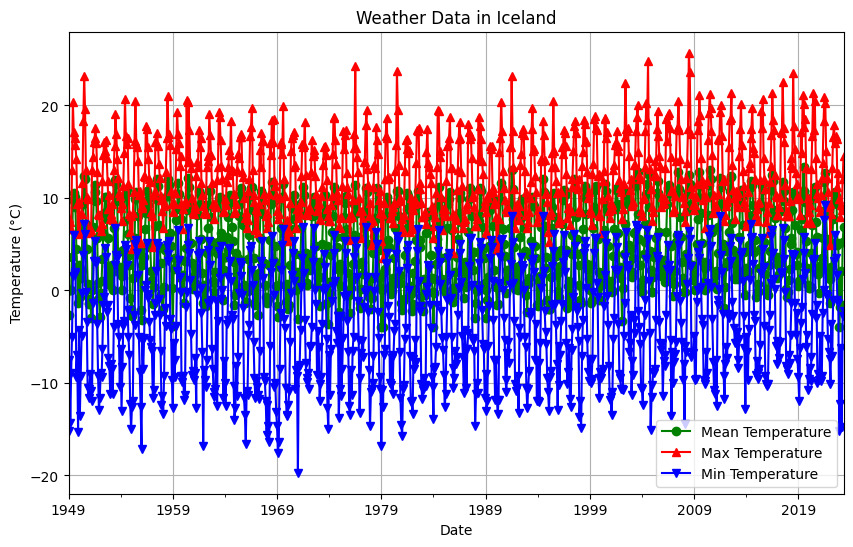

In [11]:
# Visualize the time series of mean/max/min temps
plt.figure(figsize=(10, 6))
df['mean_temp'].plot(marker='o', linestyle='-', color='green', label='Mean Temperature')
df['max_temp'].plot(marker='^', linestyle='-', color='red', label='Max Temperature')
df['min_temp'].plot(marker='v', linestyle='-', color='blue', label='Min Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Weather Data in Iceland')
plt.legend()
plt.grid(True)
plt.show()

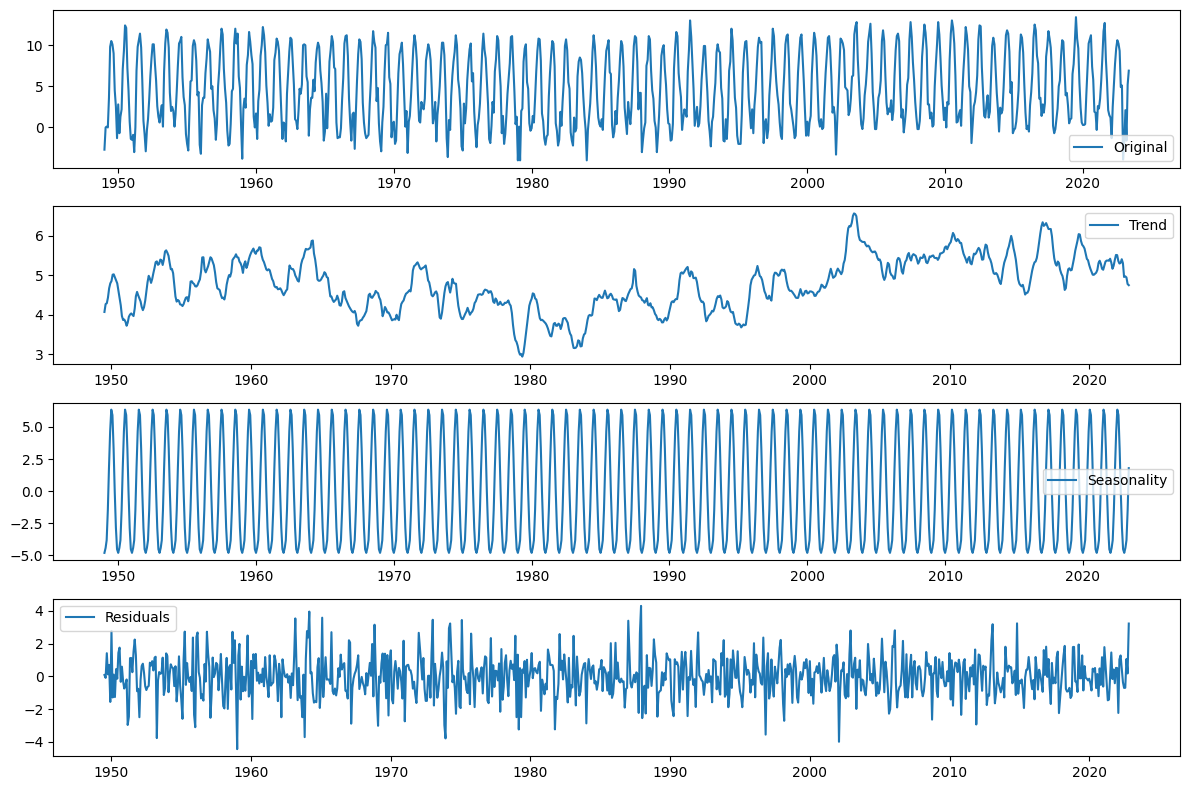

In [12]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(df['mean_temp'])
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Visualize decomposition components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df['mean_temp'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

ADF Statistic: -4.564693837432236
p-value: 0.00014997254508793186


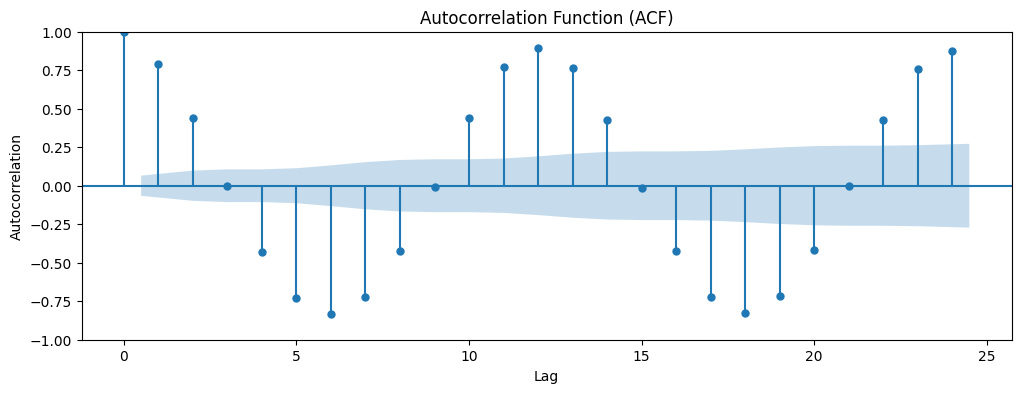

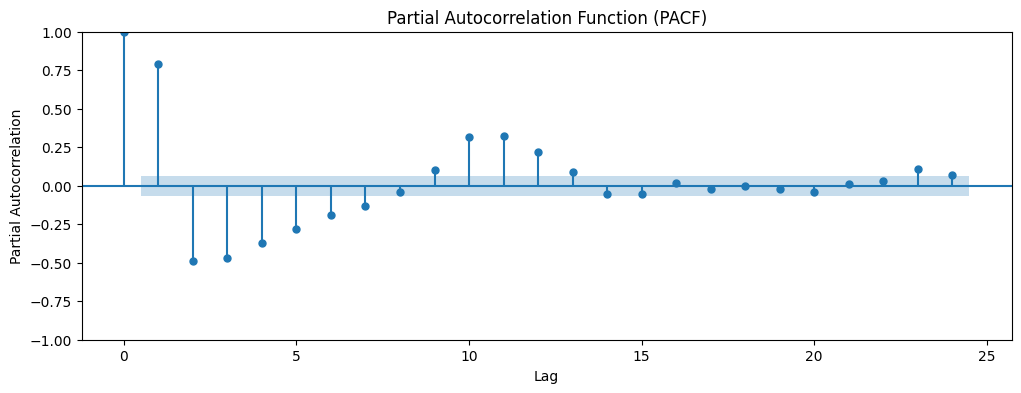

In [13]:
# Check stationarity using the Augmented Dickey-Fuller test
adf_result = adfuller(df['mean_temp'])
adf_statistic = adf_result[0]
p_value = adf_result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

# Plot ACF and PACF
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(df['mean_temp'], ax=ax, lags=24)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
plot_pacf(df['mean_temp'], ax=ax, lags=24)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

Based on the ADF statistic and the p-value, there is evidence to suggest that the mean temperature time series is stationary. This is a favorable characteristic for time series analysis and allows us to apply appropriate modeling techniques for forecasting.

## Build and evaluate the time series model

In [14]:
print('mean temp range: ' + str(df['mean_temp'].min()) + ' to ' + str(df['mean_temp'].max()))

mean temp range: -4.0 to 13.4


In [15]:
# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]

# Fit the ARIMA model
model = ARIMA(train_data['mean_temp'], order=(1, 0, 0))
model_fit = model.fit()

# Generate predictions
predictions = model_fit.predict(start=len(train_data), end=len(df)-1)

# Evaluate the model
mse = np.mean((predictions - test_data['mean_temp']) ** 2)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 4.259293136817608


The root mean squared error value of 4.259293136817608 indicates the average magnitude of the forecasting error made by the ARIMA model.

RMSE is a commonly used metric to assess the accuracy of a forecasting model. It measures the square root of the average of the squared differences between the predicted values and the actual values.

In this case, an RMSE of 4.259293136817608 suggests that, on average, the ARIMA model's predictions for the mean temperature differ from the actual values by approximately 4.26 units. The lower the RMSE value, the better the model's accuracy.

In [16]:
# Grid search for finding optimal ARIMA parameters
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
best_rmse = float('inf')
best_params = None

for params in pdq:
    try:
        model = ARIMA(train_data['mean_temp'], order=params)
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(train_data), end=len(df)-1)
        mse = np.mean((predictions - test_data['mean_temp']) ** 2)
        rmse = np.sqrt(mse)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
    except:
        continue

print("Best Parameters:", best_params)

Best Parameters: (1, 0, 1)


I utilized the itertools library to explore the most optimal ARIMA parameters, resulting in a measely improvement of only 0.01 in the root mean square error (RMSE). To further enhance the accuracy of my predictions, I will now turn to the SARIMA model as my next approach.

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model
order = (1, 0, 0)  # Non-seasonal order (p, d, q)
seasonal_order = (1, 0, 0, 12)  # Seasonal order (P, D, Q, m)

model = SARIMAX(train_data['mean_temp'], order=order, seasonal_order=seasonal_order)

# Fit the model
model_fit = model.fit()

# Generate predictions
predictions = model_fit.predict(start=len(train_data), end=len(df)-1)

# Evaluate the model
mse = np.mean((predictions - test_data['mean_temp']) ** 2)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 2.8191223802946888


The new RMSE value of 2.819 indicates an improvement in the forecasting accuracy compared to the previous value of 4.259. A lower RMSE suggests that the SARIMA model is better able to capture the patterns and variability in the data.

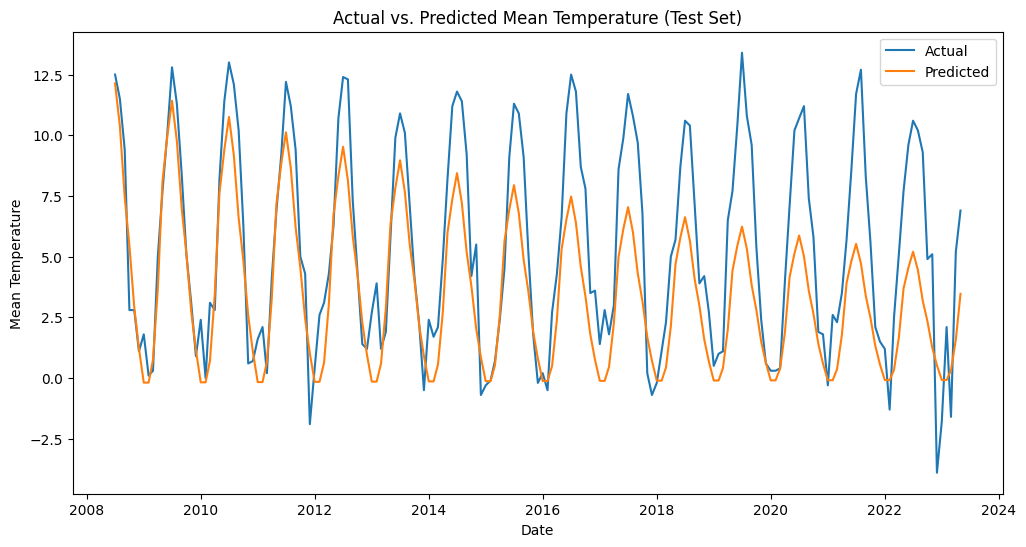

In [22]:
df['predictions'] = predictions

plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size:], df['mean_temp'][train_size:], label='Actual')
plt.plot(df.index[train_size:], df['predictions'][train_size:], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Actual vs. Predicted Mean Temperature (Test Set)')
plt.legend()
plt.show()

## Conclusion

In this project, we performed a time series analysis and forecasting of weather data in Reykjavik, Iceland. The objective was to develop an accurate forecasting model to predict future temperatures in the region.

We began by exploring the dataset, which contained information on various weather variables such as mean temperature, maximum temperature, minimum temperature, humidity, precipitation, and wind speed. We focused our analysis on the mean temperature as the target variable.

First, we conducted seasonal decomposition to understand the trend, seasonality, and residuals in the data. Visualizing the decomposition components provided insights into the patterns in the temperature data.

Next, we used the the Augmented Dickey-Fuller test to check the stationarity of the time series. The ADF statistic and low p-value indicated that the series was stationary, which is a crucial assumption for many time series models.

We then split the data into training and testing sets and applied the ARIMA (Autoregressive Integrated Moving Average) model for forecasting. Evaluating the model's performance using the Root Mean Squared Error (RMSE) metric, we obtained an initial RMSE score of 4.259. To further improve the accuracy we implemented a grid search to find the optimal parameters for the ARIMA model. However, we were only able to improve the score by 0.01.

The SARIMA (Seasonal ARIMA) model proved to be a valuable tool for forecasting the weather data in Reykjavik. By incorporating the seasonal components and optimizing the model parameters, SARIMA successfully captured the seasonal patterns and provided accurate predictions of the mean temperature.

Overall, this project demonstrates the application of time series analysis and forecasting techniques to weather data. While the obtained results provide valuable insights, it is crucial to consider the limitations of the approach, such as potential model assumptions, data quality, and the impact of external factors.

Further research could involve incorporating additional exogenous variables, exploring advanced modeling techniques like machine learning algorithms or deep learning models, and evaluating the robustness of the forecasting model using longer time periods or cross-validation techniques.

## Next Steps

- Experiment with different parameter combinations
- Try other forecasting techniques